# 1 线性回归从零实现
- 了解细致的工作原理：
  - 方便自定义模型、自定义层或自定义损失函数
- 只使用张量&自动求导

In [2]:
%matplotlib inline 
import random 
import torch

## 1.1 生成数据集
- 使用低维数据
- 带有噪声
- 生成1000个样本：
  - 每个样本包含从正态分布中采样的2个特征
  - 合成数据集为一个矩阵$\mathbf{X}\in\mathbb{R}^{1000\times2}$

- 使用线性参数$\mathbf{w}=[2,-3.4]^\top$、$b=4.2$以及$\epsilon$生成数据集和标签
  - $\epsilon$服从均值为0的正态分布
  - 将标准差设为0.01

In [3]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([1.4279, 0.2739]) 
label: tensor([6.1256])


## 1.2 读取数据集
- 训练模型时需要对数据集进行遍历，每次抽取一小批量样本，并使用其更新模型
- 需要定义一个函数：
  - 可以打乱数据集中的样本
  - 并以小批量方式获取数据
- 定义该函数为`data_iter`
  - 接收参数：批大小、特征矩阵和标签向量
  - 输出：大小为`batch_size`的小批量
- `yeild`关键字
  - `yield`与`return`的区别是，`return`会返回一个最终的值，并结束函数的执行，而`yield`可以返回多个值，并保持函数的状态
  - 可以用来在一个函数中返回一个生成器对象。生成器是一种特殊的函数，它不会一次性返回所有的值，而是每次返回一个值，然后暂停执行，直到下一次请求。
  - 当一个带有yield的函数被调用时，执行会停在`yield`语句处，并在生成器被迭代时从那里继续
- 注意：
  - 下述函数在实际应用中**执行效率很低**
  - 要求所有数据加载到内存并且执行大量随机内存访问

In [4]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # Shuffle list in place, and return None.
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor (
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [5]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y) 
    break

tensor([[-9.5216e-01,  2.5541e+00],
        [ 7.8420e-01, -2.6760e-01],
        [ 2.7995e+00, -4.6068e-01],
        [-1.9362e+00,  3.9122e-01],
        [-1.2951e+00,  7.0328e-01],
        [-7.3248e-01,  5.1956e-01],
        [-9.9845e-01, -6.4231e-01],
        [-8.6781e-01, -1.4415e+00],
        [-8.3266e-01,  2.2954e-01],
        [ 4.8541e-01, -1.2994e-03]]) 
 tensor([[-6.3802],
        [ 6.6957],
        [11.3690],
        [-1.0046],
        [-0.7848],
        [ 0.9809],
        [ 4.3920],
        [ 7.3657],
        [ 1.7546],
        [ 5.1867]])


## 1.3 初始化模型参数
- 在使用小批量随机梯度下降优化模型参数前，需要先有一些参数
  - 通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，并将偏置初始化为0
- 初始化参数后，更新它们，使得其足以拟合数据
  - 每次更新都要计算损失函数关于模型参数的梯度
  - 有该梯度，则可向减少损失的方向更新每个参数

In [6]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True) 
b = torch.zeros(1, requires_grad=True)

print("Initialized parameters:\n", "\tw = ", w, "\n\tb = ", b)

Initialized parameters:
 	w =  tensor([[0.0265],
        [0.0108]], requires_grad=True) 
	b =  tensor([0.], requires_grad=True)


## 1.4 定义模型及损失函数
- 定义模型：
  - 将模型的输入和参数同模型的输出关联起来
  - 计算输出：输入特征$\mathbf{X}$和模型权重$\mathbf{w}$的矩阵-向量乘法后再加上一个偏置$b$
- 定义损失函数：
  - 使用平方损失函数
  - 实现时，需要将真实值`y`的形状转换为和预测值`y_hat`的形状相同

In [7]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## 1.5 定义优化算法
- 定义函数实现小批量随机梯度下降更新
  - 从数据集中随机抽取⼀个⼩批量，然后根据参数计算损失的梯度
  - 朝着减少损失的⽅向更新参数
- 输入：模型参数集合、学习速率（`lr`）和批大小

In [8]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 1.6 训练
- 需要**重点理解**这部分代码，日后反复用到
- 每次迭代中，读取小批量训练样本，并通过模型来获得一组预测
- 计算完损失后，开始反向传播，存储每个参数的梯度
- 最后调用优化算法`sgd`来更新参数
- 概括而言，执行以下循环：
  - 初始化参数
  - 重复训练，直至完成：
    - 计算梯度：$\mathbf{g}\leftarrow \partial_{(\mathbf{w},b)}\frac{1}{\vert \mathcal{B}\vert}\sum_{i\in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$ 
    - 更新参数：$(\mathbf{w},b)\leftarrow (\mathbf{w},b)-\eta \mathbf{g}$
- 每个epoch，使用`data_iter`函数便利整个数据集，并将训练数据集中所有样本都使用一次
- 超参数：
  - `num_epochs=3`：迭代周期数
  - `lr=0.03`：学习率

In [9]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的小批量损失
        # 因为l形状是(batch_size,1)，⽽不是⼀个标量。l中的所有元素被加到⼀起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size) # 使⽤参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

epoch 1, loss 0.031201
epoch 2, loss 0.000108
epoch 3, loss 0.000050
w的估计误差: tensor([7.8678e-06, 2.5105e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0009], grad_fn=<RsubBackward1>)


# 2 线性回归简洁实现
## 2.1 生成并读取数据集
- 读取数据集时:
  - 调用框架中现有的API读取
  - 将`features`和`labels`作为API的参数进行传递
  - `is_train`表示是否希望数据迭代器对象在每次迭代周期内打乱数据
- 验证`data_iter`函数是否工作正常：
  - `iter`构造Python迭代器
  - `next`从迭代器中获取第一项
- `torch.utils.data.TensorDataset(*tensors)`
  - Dataset wrapping tensors.
  - Each sample will be retrieved by indexing tensors along the first dimension.
  - Parameters: tensors that have the same size of the first dimension.
- https://pytorch.org/docs/stable/data.html

In [13]:
import numpy as np
import torch
from torch.utils import data

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

# print(type(features), features.shape)
# print(type(labels), labels.shape)

def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)
next(iter(data_iter))

[tensor([[-0.9024, -1.8544],
         [ 0.5155,  0.3252],
         [-0.8818,  0.5197],
         [-1.2885, -1.6814],
         [ 2.0525, -1.6112],
         [-0.6939,  0.0654],
         [-2.3988,  0.2450],
         [ 0.0368,  0.3900],
         [-0.0907,  0.3949],
         [-0.3948, -0.0078]]),
 tensor([[ 8.7124],
         [ 4.1138],
         [ 0.6605],
         [ 7.3374],
         [13.7739],
         [ 2.5949],
         [-1.4277],
         [ 2.9623],
         [ 2.6690],
         [ 3.4386]])]

## 2.2 定义模型
- 对于标准深度学习模型，可以使用可使用框架预定义好的层
  - 只需关心使用哪些层来构造模型
  - 不必关心实现细节
- 首先定义一个模型变量`net`
  - 是一个`Sequential`类的实例，该类将多个层串联起来
  - 给定输入后，实例将数据传⼊到第⼀层，然后将第⼀层的输出作为第⼆层的输⼊
- PyTorch中，全连接层在`Linear`类中定义
  - 将两个参数传递到`nn.Linear`：
    - 第一个：指定输入特征形状，即为$2$
    - 第二个：指定输出特征形状，输出特征形状为单个标量，即$1$

In [14]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

## 2.3 初始化模型参数
- 使用`net`之前，我们要初始化模型参数
  - 线性回归模型中的权重与偏置
  - 深度学习架构通常有**预定义的⽅法**来初始化参数
  - 此处指定每个权重参数应该从均值为0、标准差为0.01的正态分布中随机采样，偏置参数将初始化为零
- 可以直接访问参数以设定他们的初始值
  - `net[0]`选择网络中的第一个图层
  - `weight.data`以及`bias.data`访问参数
  - `normal_`和`fill_`重写参数

In [15]:
net[0].weight.data.normal_(0, 0.01) 
net[0].bias.data.fill_(0)

tensor([0.])

## 2.4 定义损失函数与优化算法
- 损失函数：
  - 均方误差使用`MSELoss`类，也称平方$L_2$范数
  - 默认返回所有样本损失的平均值
- 优化算法：
  - PyTorch在`optim`模块中实现很多⼩批量随机梯度下降算法及许多变种
  - 实力化一个`SGD`实例后，需指定优化参数
    - 可通过`net.parameters()`从模型中获得

In [16]:
loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

## 2.5 训练
- 每个迭代周期，需完整遍历一次数据集，不停地从中获取⼀个⼩批量的输 ⼊和相应的标签
- 对于每⼀个⼩批量：
  - 通过调⽤`net(X)`⽣成预测并计算损失`l`（前向传播）
  - 通过进⾏反向传播来计算梯度
  - 通过调⽤优化器来更新模型参数

In [18]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

epoch 1, loss 0.000105
epoch 2, loss 0.000105
epoch 3, loss 0.000104
w的估计误差： tensor([4.1485e-05, 8.4376e-04])
b的估计误差： tensor([0.0002])


# 3 softmax回归
- 也是一种单层神经网络
   ![](https://raw.githubusercontent.com/Masshiro/TyporaImages/master/20230714141029.png)
- 使用向量形式表达：$\mathbf{o}=\mathbf{Wx}+\mathbf{b}$
- 全链接层的参数开销：
  - 具体而言：对于任何具有$d$个输入和$q$个输出的全链接层，参数开销为$\mathcal{O}(dq)$
  - 可自定义超参数$n$来减少开销至$\mathcal{O}(\frac{dq}{n})$
## 3.1 softmax运算
- 若要将输出视为概率，必须保证在任何数据上的输出都是非负且总和为1
- 同时需要一个训练的目标函数，来激励模型估计概率
- softmax函数：将为规范化的预测变换为⾮负数并且总和为1，同时让模型保持可导的性质：
  - $$\hat{\mathbf{y}}=\text{softmax}(\mathbf{o}), \;\text{ where } \hat{y}_j=\frac{\exp(o_j)}{\sum_{k}\exp(o_k)}$$

## 3.2 图像分类数据集
- 使用类似MNIST但更复杂的Fashion-MNIST数据集
- 使用`ToTensor`实例将图像数据从PIL类型转换为32位浮点数格式

In [33]:
import torch 
import torchvision 
from torch.utils import data 
from torchvision import transforms
import matplotlib.pyplot as plt

trans = transforms.ToTensor() 

mnist_train = torchvision.datasets.FashionMNIST(
    root="../dataset", train=True, transform=trans, download=True) 

mnist_test = torchvision.datasets.FashionMNIST(
    root="../dataset", train=False, transform=trans, download=True)

- Fashion-MNIST由10个类别的图像组成
  - 每个类别：训练数据集（6000张）+ 测试数据集（1000张）
- 每个输入图像的高度与宽度均为28像素
  - 数据由灰度图像组成，通道数为1

In [25]:
print(len(mnist_train), len(mnist_test))
print(mnist_train[0][0].shape)

60000 10000
torch.Size([1, 28, 28])


- Fashion-MNIST中包含10个类别
- 以下函数⽤于在数字标签索引及其⽂本名称之间进⾏转换

In [29]:
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

- 训练集中，前几个样本的图像及其对应的标签

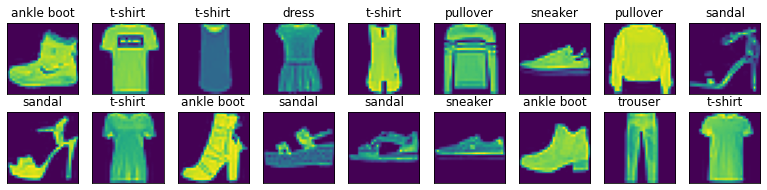

In [34]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

- 整合组件，定义`load_data_fashion_mnist`函数：
  - 返回值：训练集、验证集的数据迭代器
  - 输入参数：`resize`，将图像大小调整为另一种形状

In [35]:
batch_size = 256

def get_dataloader_workers():
    return 4

def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../dataset", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../dataset", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

# 4 softmax从零开始实现


In [36]:
import torch
from IPython import display

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)